In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier
#!pip3 install -U lazypredict
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output


In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((8693, 14), (4277, 13))

In [8]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [9]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [11]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

# **EDA**

<AxesSubplot:xlabel='Transported', ylabel='count'>

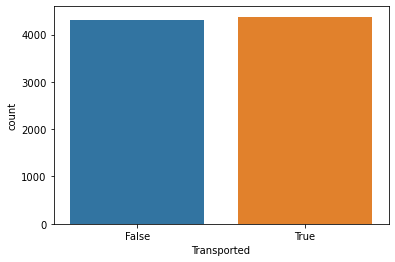

In [12]:
sns.countplot(train['Transported'])

In [13]:
HomeTransported = train.groupby(['HomePlanet', 'Transported']).size()
HomeTransported

HomePlanet  Transported
Earth       False          2651
            True           1951
Europa      False           727
            True           1404
Mars        False           839
            True            920
dtype: int64

In [14]:
DestinationTransported = train.groupby(['Transported', 'Destination']).size()
DestinationTransported

Transported  Destination  
False        55 Cancri e       702
             PSO J318.5-22     395
             TRAPPIST-1e      3128
True         55 Cancri e      1098
             PSO J318.5-22     401
             TRAPPIST-1e      2787
dtype: int64

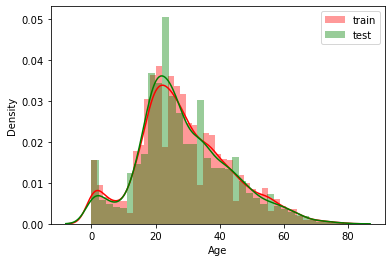

In [15]:
# age distribution
sns.distplot(train['Age'], color='red', label='train')
sns.distplot(test['Age'], color='green', label='test')
plt.legend()

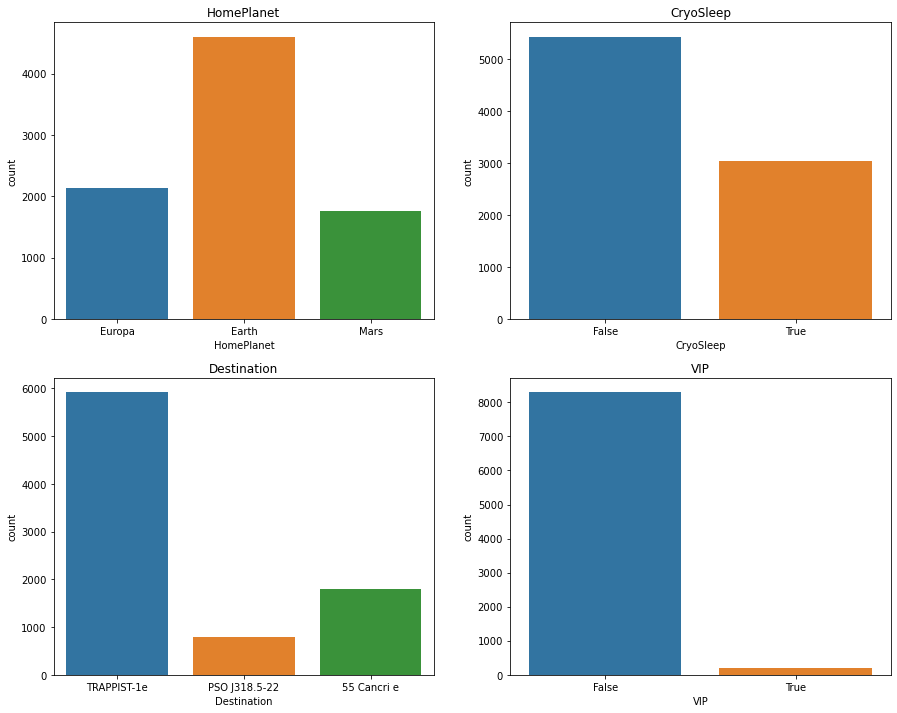

In [16]:
# count plots for the unique features
cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig, ax = plt.subplots(2,2, figsize=(15, 12))
for i, col in enumerate(cols):
    plt.subplot(2,2,i+1)
    sns.countplot(train[col])
    plt.title(col)

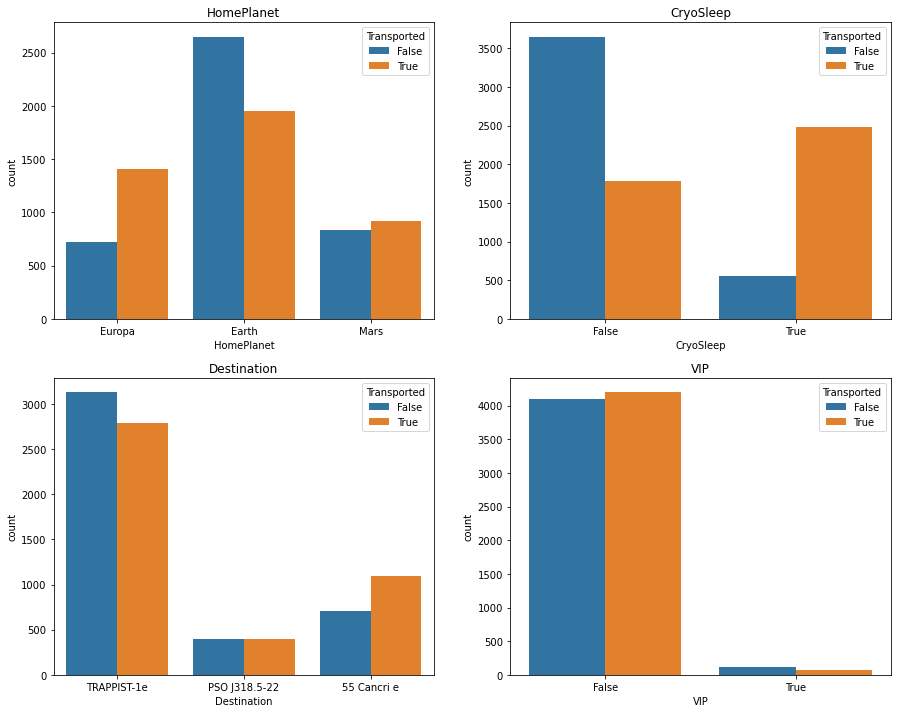

In [17]:
# count plot in relation to the target feature(Transported)
cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig, ax = plt.subplots(2,2, figsize=(15, 12))
for i, col in enumerate(cols):
    plt.subplot(2,2,i+1)
    sns.countplot(train[col], hue=train['Transported'])
    plt.title(col)

<AxesSubplot:>

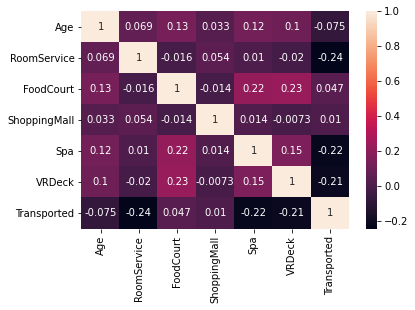

In [18]:
sns.heatmap(train.corr(), annot=True)

In [19]:
# imputing missing values
imputer_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
imputer = SimpleImputer(strategy='median')
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])

In [20]:
train['HomePlanet'].fillna('Z', inplace=True)
test['HomePlanet'].fillna('Z', inplace=True)
train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin           199
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

In [21]:
# encoding categorical features
label_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test
train, test = label_encoder(train, test, label_cols)

In [22]:
train.drop('PassengerId', axis=1, inplace=True)

train.drop(['Name', 'Cabin'], axis=1, inplace=True)
test.drop(['Name', 'Cabin'], axis=1, inplace=True)
X = train.drop('Transported', axis=1)
y = train['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, test_size=0.33)

# **Modeling**

In [23]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, 
                     predictions=False,random_state=12, classifiers='all')
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
#clear_output()

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:27<00:00,  1.05it/s]


In [24]:
models[:15]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.79,0.79,0.79,0.38
XGBClassifier,0.78,0.78,0.78,0.78,0.81
AdaBoostClassifier,0.77,0.77,0.77,0.77,0.90
RandomForestClassifier,0.77,0.77,0.77,0.77,1.98
NuSVC,0.77,0.77,0.77,0.77,4.78
LogisticRegression,0.77,0.77,0.77,0.77,0.33
SVC,0.77,0.77,0.77,0.77,3.76
ExtraTreesClassifier,0.76,0.76,0.76,0.76,1.40
LinearSVC,0.76,0.76,0.76,0.76,0.61


# **5 fold LGBM Classifier**

In [25]:
lgb_params = {
    'objective': 'binary', 
    'n_estimators': 50,
    'learning_rate': 0.08
}
lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train['Transported'])):
    print('')
    start_time = time.time()
    
    X_train, X_valid =train.iloc[train_idx][LGBM_FEATURES],train.iloc[valid_idx][LGBM_FEATURES]
    y_train, y_valid = train['Transported'].iloc[train_idx], train['Transported'].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train, verbose=0)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time
    
    fim = pd.DataFrame(index=LGBM_FEATURES, data=model.feature_importances_,
                      columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    print(f'Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s')
    test_preds = model.predict(test[LGBM_FEATURES])
    lgb_predictions += test_preds/5
    print('')
print('Mean Accuracy: ', np.mean(lgb_scores))


Fold=1, Accuracy score: 0.81%, Run Time: 0.16s


Fold=2, Accuracy score: 0.78%, Run Time: 0.16s


Fold=3, Accuracy score: 0.79%, Run Time: 0.15s


Fold=4, Accuracy score: 0.79%, Run Time: 0.16s


Fold=5, Accuracy score: 0.81%, Run Time: 0.16s

Mean Accuracy:  0.7958136330880743


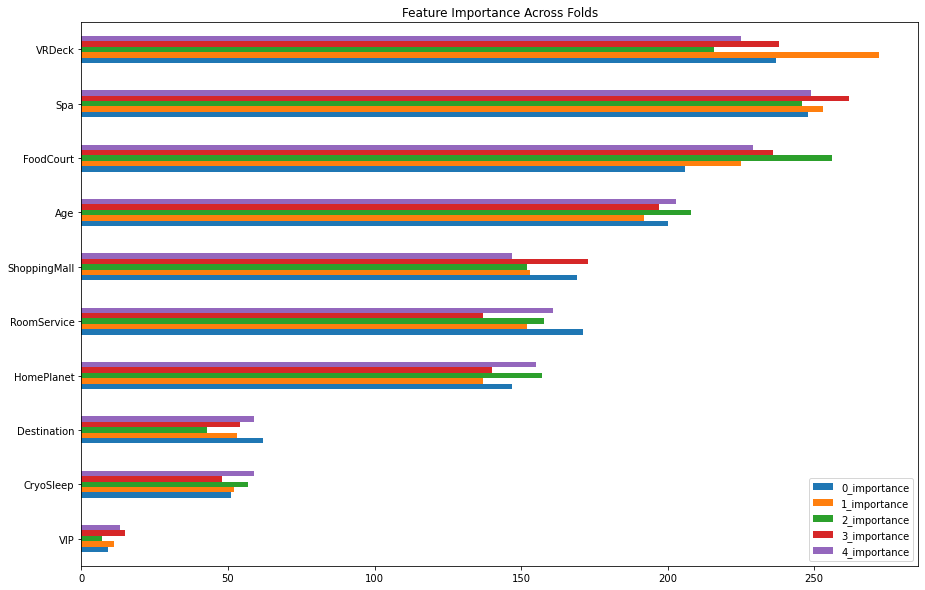

In [26]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10), title='Feature Importance Across Folds')
plt.show()

In [27]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Transported': lgb_predictions.astype('bool')})
output.to_csv('submission.csv', index=False)
output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
